# This Notebook is for EDA and Clean-up of the provided data set for the Machine Learning course

## Set Up

In [147]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings
import json

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SkLearn  Data Prep
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from imblearn.over_sampling import SMOTE

# SkLearn Measurement Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score

# SkLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_blobs
from sklearn import ensemble

# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [148]:
# Get Main Data
path = os.getcwd()
path = path +'\\medical_data\\'
file = 'data.csv'

mainData = pd.read_csv(path+file)
mainData.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
0,24437208,135,Caucasian,Female,[50-60),NaN,2,1,1,8,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
1,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2,189899286,729,Caucasian,Female,[80-90),NaN,1,3,7,4,...,No,No,No,No,No,No,No,No,Yes,NO
3,64331490,774,Caucasian,Female,[80-90),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,NO
4,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO


In [149]:
# Get Admission Type Look-Up
file = 'id_lookup.csv'
admissionTypeLookUp = pd.read_csv(path+file)
admissionTypeLookUp = admissionTypeLookUp.iloc[:8]
admissionTypeLookUp['admission_type_id'] = admissionTypeLookUp['admission_type_id'].astype(int)
admissionTypeLookUp

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [150]:
# Set Aside Copy of DF for Experiments
expData = mainData

In [151]:
# set plot export paths:
plotLoc = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/Machine-Learning/Final-Project-Plots/Final-Project/'
exportPath = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/Machine-Learning/Final-Project-Plots/Final-Project/'

In [152]:
#TEMP -- Sample Main Data to make code faster to run for debugging/ quick experiments
#mainData = mainData.sample(1000)
#mainData.shape

# Re-Usable Functions

In [153]:
# Takes a DF and Producecs a Report of Null Values
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per","Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [154]:
# Takes a DF, list of variable,and an order and returns a DF w/ ordinal encoding
def OrdinalEncoderFunc (df,listOfVars,order):
    enc = OrdinalEncoder(categories=[order])
    for col in listOfVars:
        col=col
        df[col] = enc.fit_transform(df[[col]])
    return df

In [155]:
def target_encoder(df, var, var1): #var1 needs to be a target (numerical not categorical)
    tenc = ce.TargetEncoder()
    df[var] = (tenc.fit_transform(df[[var]], df[[var1]]))
    return df

In [156]:
# Custom Clean-Up Function For This Dataset -- 1
def EncodeResponse (df):
    # Execute Encoding
    dummyTemp = pd.get_dummies(df['readmitted'],prefix='readmitted_')
    df = df.join(dummyTemp)
    # Customize/ Clean-Up
    ## Make 'readmitted' more logical so it is 0 when no and 1 when yes
    df = df.drop(columns=['readmitted']) # Drop Old Readmitted Column
    df = df.rename(columns={'readmitted__NO': 'readmitted'}) # Rename encoded column
    df = df.dropna(subset=['readmitted']) # drop puzzling 1 nan value
    df['readmitted'] = df['readmitted'].map({0:1, 1:0}) # reverse encoding to make logical
    return df


In [157]:
# Custom Clean-Up Function For This Dataset -- 2
# TODO: Clean-up for demographic Vars (age, gender, race)

def AdditionalClean (df):
    #1 - Null Clean-Up2 -- Fillna's for variables with nulls that have value to keep
    df['race'] = df['race'].fillna('Unknown')
    #2 - Race to Dummy Vars
    dummyTemp = pd.get_dummies(df['race'],prefix='race_')
    df = df.join(dummyTemp)
    df = df.drop(columns=['race'])
    #2 - Encode Gender
    number = LabelEncoder()
    df['gender'] = number.fit_transform(df['gender']) # F -> 1, M -> 0, Unknown -> 2
    #3 - Encode diabetesMed
    df['diabetesMed'] = number.fit_transform(df['diabetesMed']) # Yes -> 1, No -> 0
    #4 Custom Encode 1 -  A1Cresult
    mapping_a1 = {'None':0,'Norm':0,'>7':1,'>8':2}
    df['A1Cresult'] = df['A1Cresult'].map(mapping_a1)
    #5 Custom Encode 2 -  max_glu_serum
    mapping_glu = {'None':0,'Norm':0,'>200':1,'>300':2}
    df['max_glu_serum'] = df['max_glu_serum'].map(mapping_glu)
    #6 Custom Encode 3 - change
    mapping_change = {'No':0,'Ch':1,}
    df['change'] = df['change'].map(mapping_change)
    #7 - Convert Age Buckets to Single Numeric
    df['age'] = df['age'].str[1:3]
    df['age'] = df['age'].str.rstrip('-')
    df['age'] = df['age'].astype('int')
    df = df.rename(columns={'age': 'age_10yrStart'})
    return df

In [158]:
# Main Clean DF Function -- Wraps Clean-Up Steps into one function so I can run on multiple versions of a DF
## Does not include steps for cleaning response variable.

def Clean_DF_Wrapper (df_to_clean,ordEncode_Vars,ordEncode_order,medCols):

    # Null Clean-Up1 -- Drop Columns with high % of nulls, that aren't worth filling
    df_to_clean = df_to_clean.drop(columns=['weight','medical_specialty','payer_code'])

    # Diag Clean-Up
    ## If diag_2 is null, then use diag_3.  If diag_1 is null, then use diag_2
    ## Solves all but 1 null Diag1, which is dropped
    ## TODO: Determine how to drop value from column that I pull from.
    df_to_clean['diag_2'] = df_to_clean['diag_2'].fillna(df_to_clean['diag_3'])
    df_to_clean['diag_1'] = df_to_clean['diag_1'].fillna(df_to_clean['diag_2'])
    df_to_clean = df_to_clean.dropna(subset=['diag_1'])

    # Remove Deceased Patients
    ## Note: The research question is about predicting what patients will be re-admitted.
    ## In order to not skew the results, patients who died while admitted should be removed from the prediction
    ## Note: I only removed cases that explicity said the patient expired. not hospice patients (13,14)
    expCodes = ['11','19','20','21','13','14']
    df_to_clean = df_to_clean[~df_to_clean['discharge_disposition_id'].isin(expCodes)]

    # Call OrdinalEncoder Function
    df_to_clean  = OrdinalEncoderFunc(df_to_clean,ordEncode_Vars,ordEncode_order)

    # Add Variable For Number of Medications
    df_to_clean['num_of_meds'] = df_to_clean[medCols].ne(0).sum(axis=1)

    # Add Variable for Medication Level Up Or Down
    ## In the Medication columns 1 signifies that dosage decreased, 3 signifies that dosage increased
    ## This counts the number of 1 and coverts to a negative, then the adds the number of 3
    ## Result indicates the net level of medication change
    df_to_clean['med_level_direction'] = ((df_to_clean[medCols] == 1).sum(axis=1)*-1) + \
                                  (df_to_clean[medCols] == 3).sum(axis=1)
    ## Same logic - but adding the number of meds that the levels changed
    df_to_clean['num_meds_changed'] = (df_to_clean[medCols] == 1).sum(axis=1) + \
                                  (df_to_clean[medCols] == 3).sum(axis=1)
    # Combine Patient Visit Vars into One Feature
    df_to_clean['patientVists'] = df_to_clean['number_emergency'] + df_to_clean['number_inpatient'] \
                          + df_to_clean['number_outpatient']
    df_to_clean= df_to_clean.drop(columns=['number_emergency','number_inpatient','number_outpatient'])

    # Call Function w/ all custom clean-up steps
    df_to_clean = AdditionalClean(df_to_clean)

    return df_to_clean

In [159]:
# Clean DF Function For Response -- Wraps Steps into one function so I can run on multiple versions of a DF
## Seems strange that it only calls another function, wanted structure in case I added other steps

def Clean_ResponseVar (df_to_clean):
    df_to_clean = EncodeResponse(df_to_clean)
    return df_to_clean


In [160]:
#  Split function - Takes a df and list of predictor vars and specified response var and
##  returns x/y test/train sets.
## Note: update params if you want reproducable splits or not
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test


In [161]:
# Takes a model, and test sets and returns and ROC Curve w/ AUC value

def ROC_Curve_Plot(model,roc_x_test,roc_y_test):
    #new section
    #old section
    probas = model.predict_proba(roc_x_test) # get the probability distribution
    fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    roc_auc = auc(fpr, tpr) # get area under curve
    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    return plt

# Source: https://medium.com/@gaurav_bio/making-sense-of-real-world-data-roc-curves-and-when-to-use-them-90a17e6d1db

In [162]:
# Takes a model and various split sets and returns a CM plot w/ Accuracy

def createConfMatrix (regObj, y_test, y_pred, x_test):
    # Logistic Regression -- Step 5 -- Create Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm.columns.name = 'Predicted'
    cm.index.name = 'True'
    # Logistic Regression -- Step 6 -- Calc Accuracy From Test Set
    score = regObj.score(x_test, y_test)
    score = round(score,4)
    return cm, score

In [163]:
# Takes test and predicted sets and returns precision/recall metrics
def summaryStats (model_name, y_test, y_pred, SummaryDF):
    # Collect Stats
    row =[]
    accuracy = round(accuracy_score(y_test, y_pred),4)
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    f1 = round(f1_score(y_test, y_pred),4)
    #probas = model.predict_proba(roc_x_test) # get the probability distribution
    #fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    #roc_auc = auc(fpr, tpr) # get area under curve
    # Collect Results
    row = [model_name,accuracy, precision, recall, f1]
    # append stats to Summary Stats DF
    df = SummaryDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [164]:
# Takes a model and returns a Feature Importance Plot

def FeatureImportance (model,featureList):
    # Best Tree-- Plot Most Important Features
    importances = model.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=featureList)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

In [165]:
# Takes a DF and returns an elbow plot for KMeans in order to determine the proper K Value
## Think of as KMeans Pre-Analysis

def KMeansElbowPlot(df):
    # Elbow Method -- To Set K Range
    k_rng = range(1,10)
    # sum of square error
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters=k)
        km.fit(df)
        sse.append(km.inertia_)
    # Elbow Plot w / SSE
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.plot(k_rng,sse)
    return plt

In [166]:
# Takes a DF, list of Predictor Vars, and Response Var and returns an elbow plot to determine optimal P.C.'s

def PCA_PreProcess_Elbow(df,PredictorVar,ResponseVar):
    # PCA -- CV
    upper = len(PredictorVar)
    row =[]
    pca_Result = pd.DataFrame(columns = ["Number_Variables","MSE",'RMSE',"Variance_Explained"])
    kf = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)
    # Function Call To prep train/test
    for i in range(upper):
        x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar[:i+1], ResponseVar)
        pca = PCA()
        x = pca.fit_transform(scale(x_test))
        regr = LinearRegression()
        regr.fit(x_train, y_train)
        score = -1*model_selection.cross_val_score(regr, x_test, y_test, cv=kf,
                                               scoring='neg_mean_squared_error').mean()
        varExplained = 1-(pca.explained_variance_ratio_[i])
        RMSE = np.sqrt(score)
        row = [i,score,RMSE,varExplained]
        df_length = len(pca_Result)
        pca_Result.loc[df_length] = row
    # PCA -- plot
    sns.set_style("whitegrid")
    sns.set(rc = {'figure.figsize':(5,5)})
    fig, (ax1,ax2) = plt.subplots(ncols=2,sharex=True, sharey=False, figsize=(15,9))
    sns.lineplot(
        data=pca_Result, ax=ax1,
        x="Number_Variables", y="MSE",
        marker="o", dashes=False)
    sns.lineplot(
        data=pca_Result, ax=ax2,
        x="Number_Variables", y="Variance_Explained",
        marker="o", dashes=False)
    return plt

In [167]:
# Run PCA on a given set after determined optimal number of features (m) w/ the Pre-Process Function.

def PCA_Actual(df,PCA_relevant_features,numFeatures):
    # Make a temp set w/ just PCA_PredictorVars
    tempSet = df[PCA_relevant_features]
    # PCA -- Run Actual on Set w/ Num Features Defined On Temp Set -- Produce Array
    pca_BestM = PCA(n_components=numFeatures, random_state=1)
    X_scaled = scale(tempSet)
    pca_BestM.fit(X_scaled)
    X_pca_bestM = pca_BestM.transform(X_scaled)
    # Convert Array into DF
    PC_Cols = []
    for i in range(numFeatures):
        num=str(i+1)
        PC_Cols.append("PC"+num)
    PCA_ResultsDF = pd.DataFrame(X_pca_bestM, columns=PC_Cols)
    #df = df.reset_index()
    #df = df.join(PCA_ResultsDF)
    df = pd.merge(df,PCA_ResultsDF, left_index=True, right_index=True)
    #print(len(df))
    # Drop PredictorVars -- replace w/ P.C
    df = df.drop(columns=PCA_relevant_features)
    # reset new Predictor Var List
    PredictorVar = df.columns.values.tolist()
    return df, PredictorVar

In [168]:
def quickModelComparison(models,qe_x_train,qe_x_test, qe_y_train,qe_y_test, qe_summaryDF):
    i=0
    sc_X = StandardScaler()
    qe_x_train_scaled = sc_X.fit_transform(qe_x_train)
    qe_x_test_scaled = sc_X.transform(qe_x_test)
    for model in models:
        # Model Name -- TODO
        model_name = str(models[i])
        split_string = model_name.split("(", 1)
        model_name = split_string[0]
        i=i+1
        #fit
        model.fit(qe_x_train_scaled,qe_y_train)
        # Make Predictions
        y_pred_qe = model.predict(qe_x_test_scaled)
        # summary
        qe_summaryDF = summaryStats(model_name,qe_y_test, y_pred_qe, qe_summaryDF)
        # PLOT ROC curve -- TODO
    return qe_summaryDF

# EDA

In [169]:
# Data Shape
print(f"Data shape:",mainData.shape)

Data shape: (71518, 50)


In [170]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71518 entries, 0 to 71517
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              71518 non-null  int64 
 1   patient_nbr               71518 non-null  int64 
 2   race                      69570 non-null  object
 3   gender                    71518 non-null  object
 4   age                       71518 non-null  object
 5   weight                    2853 non-null   object
 6   admission_type_id         71518 non-null  int64 
 7   discharge_disposition_id  71518 non-null  int64 
 8   admission_source_id       71518 non-null  int64 
 9   time_in_hospital          71518 non-null  int64 
 10  payer_code                40475 non-null  object
 11  medical_specialty         37041 non-null  object
 12  num_lab_procedures        71518 non-null  int64 
 13  num_procedures            71518 non-null  int64 
 14  num_medications       

In [171]:
# Describe
mainData.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
count,7.151800e+04,7.151800e+04,69570,71518,71518,2853,71518.000000,71518.000000,71518.000000,71518.00000,...,71518,71518,71518,71518,71518,71518,71518,71518,71518,71518
unique,NaN,NaN,5,3,10,9,NaN,NaN,NaN,NaN,...,1,4,4,2,1,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),[75-100),NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,53491,38025,18210,1195,NaN,NaN,NaN,NaN,...,71518,34921,71016,71511,71518,71516,71517,39494,54319,42985
mean,1.568156e+08,5.505160e+07,NaN,NaN,NaN,NaN,2.100254,3.593235,5.657457,4.28913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.003769e+08,3.947573e+07,NaN,NaN,NaN,NaN,1.508301,5.269771,4.162580,2.94921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.145807e+07,2.337577e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.440574e+08,4.816680e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,3.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.155513e+08,8.752222e+07,NaN,NaN,NaN,NaN,3.000000,3.000000,7.000000,6.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
numericFeatures = mainData.select_dtypes(include= np.number)
numericFeatures = numericFeatures.drop(columns=['encounter_id','patient_nbr'])
numericFeatures.nunique()

admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          116
num_procedures                7
num_medications              75
number_outpatient            33
number_emergency             18
number_inpatient             13
number_diagnoses             16
dtype: int64

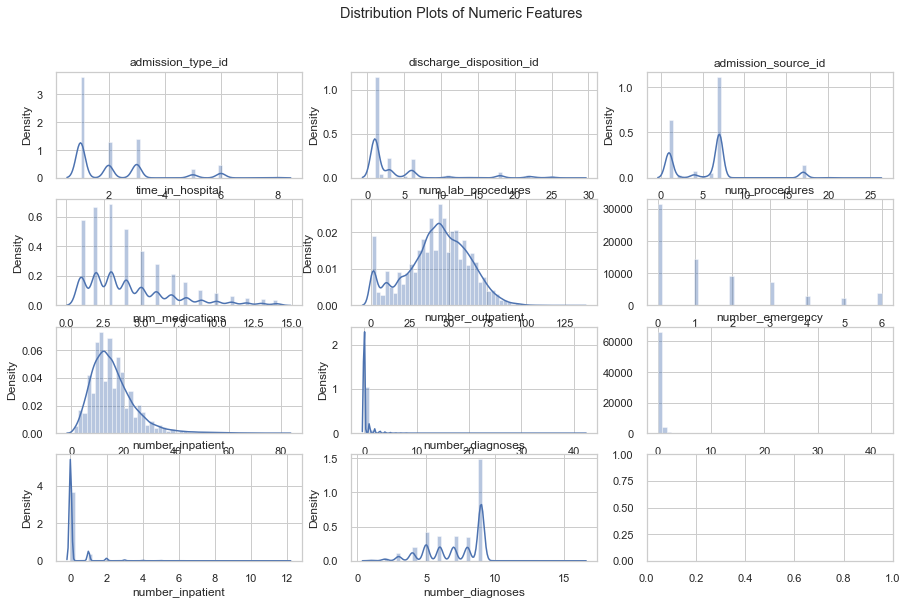

In [173]:
# Distribution Plots

fig, axes = plt.subplots(4,3, sharex=False, sharey=False, figsize=(15,9))
fig.suptitle('Distribution Plots of Numeric Features')

sns.distplot(numericFeatures['admission_type_id'], ax=axes[0,0], kde=True).set(title='admission_type_id')
sns.distplot(numericFeatures['discharge_disposition_id'], ax=axes[0,1], kde=True).set(title='discharge_disposition_id')
sns.distplot(numericFeatures['admission_source_id'], ax=axes[0,2], kde=True).set(title='admission_source_id')
sns.distplot(numericFeatures['time_in_hospital'], ax=axes[1,0], kde=True).set(title='time_in_hospital')
sns.distplot(numericFeatures['num_lab_procedures'], ax=axes[1,1], kde=True).set(title='num_lab_procedures')
sns.distplot(numericFeatures['num_procedures'], ax=axes[1,2], kde=False).set(title='num_procedures')
sns.distplot(numericFeatures['num_medications'], ax=axes[2,0], kde=True).set(title='num_medications')
sns.distplot(numericFeatures['number_outpatient'], ax=axes[2,1], kde=True).set(title='number_outpatient')
sns.distplot(numericFeatures['number_emergency'], ax=axes[2,2], kde=False).set(title='number_emergency')
sns.distplot(numericFeatures['number_inpatient'], ax=axes[3,0], kde=True).set(title='number_inpatient')
sns.distplot(numericFeatures['number_diagnoses'], ax=axes[3,1], kde=True).set(title='number_diagnoses')

plt.show()

In [174]:
# sns.pairplot(numericFeatures)

## General Data Clean-Up

In [175]:
# Print Null Summary
nullSummary = nullAnalysis(mainData)
nullSummary

Count of Variables: 50
Count of Variables without nulls: 43
Count of Variables with null : 7


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
5,weight,71518,68665,96.011,9,object
11,medical_specialty,71518,34477,48.207,70,object
10,payer_code,71518,31043,43.406,17,object
2,race,71518,1948,2.724,5,object
20,diag_3,71518,1225,1.713,758,object
19,diag_2,71518,294,0.411,725,object
18,diag_1,71518,11,0.015,696,object


In [176]:
# Specify Medications for Encoding
medCols = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone']

# Set Function Params
df_to_clean = mainData
ordEncode_Vars = medCols
ordEncode_order = ['No','Down','Steady','Up']

cleanDF = Clean_DF_Wrapper(df_to_clean,ordEncode_Vars,ordEncode_order,medCols)
cleanDF = Clean_ResponseVar(cleanDF)
cleanDF.sample(3)

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,patientVists,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted__<30,readmitted__>30,readmitted
65063,133754490,106348437,0,80,2,4,7,2,26,0,...,0,0,0,1,0,0,0,0,0,0
42063,147893640,62044308,0,70,2,1,1,4,40,2,...,0,1,0,0,0,0,0,0,0,0
67570,215561010,112442247,0,70,2,6,7,5,60,0,...,0,0,0,1,0,0,0,0,1,1


In [177]:
# Re-Run Null Summary
nullSummary = nullAnalysis(cleanDF)
nullSummary

Count of Variables: 55
Count of Variables without nulls: 53
Count of Variables with null : 2


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
13,diag_3,69973,1224,1.749,756,object
12,diag_2,69973,243,0.347,723,object


In [178]:
# Diag Encoders --
target_encoder(cleanDF,'diag_1', 'readmitted')
target_encoder(cleanDF,'diag_2', 'readmitted')
target_encoder(cleanDF,'diag_3', 'readmitted')
cleanDF.sample(3)

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,patientVists,race__AfricanAmerican,race__Asian,race__Caucasian,race__Hispanic,race__Other,race__Unknown,readmitted__<30,readmitted__>30,readmitted
38345,162194556,55943001,1,60,1,1,7,6,46,0,...,0,0,0,1,0,0,0,0,0,0
44884,264552582,68291919,1,60,1,1,7,3,23,2,...,0,0,0,1,0,0,0,0,0,0
17846,72181710,23368095,1,70,2,1,17,3,8,0,...,2,0,0,1,0,0,0,0,0,0


In [179]:
# Engineer Discharge ID

### Group Discharge Codes
cleanDF['new_discharge_disposition_id'] = cleanDF['discharge_disposition_id']

mapping_discharge = {1:'Home',6:'Home',8:'Home',
                     13:'Hospice',14:'Hospice',
                     2:'OtherCareFacility',3:'OtherCareFacility',4:'OtherCareFacility',5:'OtherCareFacility',
                     10:'OtherCareFacility',24:'OtherCareFacility',27:'OtherCareFacility',
                     28:'OtherCareFacility',29:'OtherCareFacility',30:'OtherCareFacility',
                     22:'ToRehab',23:'ToRehab',
                     7:'LeaveAMA',
                     12:'ToOutpatient',16:'ToOutpatient',17:'ToOutpatient',
                     9:'TransferInHospital',15:'TransferInHospital',
                     18:'Unknown/Invalid',25:'Unknown/Invalid',26:'Unknown/Invalid',}

cleanDF['new_discharge_disposition_id'] = cleanDF['new_discharge_disposition_id'].map(mapping_discharge)
cleanDF['new_discharge_disposition_id'].value_counts(dropna=False)

Home                  52679
OtherCareFacility     11901
Unknown/Invalid        3252
ToRehab                1670
LeaveAMA                409
TransferInHospital       49
ToOutpatient             13
Name: new_discharge_disposition_id, dtype: int64

In [180]:
# Engineer Discharge ID

### Dummy Encode
dummyTemp_discharge = pd.get_dummies(cleanDF['new_discharge_disposition_id'],prefix='discharge')
cleanDF = cleanDF.join(dummyTemp_discharge)
    # Customize/ Clean-Up
    ## Make 'readmitted' more logical so it is 0 when no and 1 when yes
cleanDF = cleanDF.drop(columns=['new_discharge_disposition_id']) # Drop Old Readmitted Column



In [181]:
# Feature Engineer Admission ID

### Group Discharge Codes
cleanDF['new_admission_type_id'] = cleanDF['admission_type_id']

mapping_addmission = {1:'Emergency',2:'Emergency',7:'Emergency',
                     3:'Elective',
                     4:'Newborn',
                     5:'Unknown/Invalid',6:'Unknown/Invalid',8:'Unknown/Invalid'}

cleanDF['new_admission_type_id'] = cleanDF['new_admission_type_id'].map(mapping_addmission)
cleanDF['new_admission_type_id'].value_counts(dropna=False)

Emergency          48286
Elective           13785
Unknown/Invalid     7893
Newborn                9
Name: new_admission_type_id, dtype: int64

In [182]:
# Feature Engineer Admission ID

### Dummy Encode
dummyTemp_admission = pd.get_dummies(cleanDF['new_admission_type_id'],prefix='admission')
cleanDF = cleanDF.join(dummyTemp_admission)
    # Customize/ Clean-Up
    ## Make 'readmitted' more logical so it is 0 when no and 1 when yes
cleanDF = cleanDF.drop(columns=['new_admission_type_id']) # Drop Old Readmitted Column
cleanDF

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,discharge_LeaveAMA,discharge_OtherCareFacility,discharge_ToOutpatient,discharge_ToRehab,discharge_TransferInHospital,discharge_Unknown/Invalid,admission_Elective,admission_Emergency,admission_Newborn,admission_Unknown/Invalid
0,24437208,135,0,50,2,1,1,8,77,6,...,0,0,0,0,0,0,0,1,0,0
1,29758806,378,0,50,3,1,1,2,49,1,...,0,0,0,0,0,0,1,0,0,0
2,189899286,729,0,80,1,3,7,4,68,2,...,0,1,0,0,0,0,0,1,0,0
3,64331490,774,0,80,1,1,7,3,46,0,...,0,0,0,0,0,0,0,1,0,0
4,14824206,927,0,30,1,1,7,5,49,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71513,418513058,189351095,0,80,1,1,7,1,73,1,...,0,0,0,0,0,0,0,1,0,0
71514,359719064,189365864,1,60,1,1,7,3,56,1,...,0,0,0,0,0,0,0,1,0,0
71515,338462954,189445127,0,80,1,1,7,3,39,0,...,0,0,0,0,0,0,0,1,0,0
71516,443811536,189481478,0,40,1,4,7,14,69,0,...,0,1,0,0,0,0,0,1,0,0


### Join Datasets -- Replace Look-Up Values With Literal Values

In [183]:
# Add Admission Type Values (Note: Did not drop ID)

# Add Column
cleanDF.insert(5,"admission_type_value", 0)

# Left Join
cleanDF = pd.merge(cleanDF,admissionTypeLookUp,on='admission_type_id')

# Replace Values
cleanDF['admission_type_value'] = cleanDF['description']
cleanDF = cleanDF.drop(columns=['description'])
cleanDF.sample(3)

,encounter_id,patient_nbr,gender,age_10yrStart,admission_type_id,admission_type_value,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,discharge_LeaveAMA,discharge_OtherCareFacility,discharge_ToOutpatient,discharge_ToRehab,discharge_TransferInHospital,discharge_Unknown/Invalid,admission_Elective,admission_Emergency,admission_Newborn,admission_Unknown/Invalid
11632,249599322,106311465,1,50,2,Urgent,1,1,1,36,...,0,0,0,0,0,0,0,1,0,0
41085,158086644,40886559,1,60,1,Emergency,22,7,3,54,...,0,0,0,1,0,0,0,1,0,0
14653,86953998,14189319,1,40,3,Elective,1,1,7,54,...,0,0,0,0,0,0,1,0,0,0


# Run Models

In [184]:
# create copy of cleanDF
tempModelingDF = cleanDF

In [185]:
# Create DF for Capturing Model Results
statRow = []
summaryStatsDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

## Prep -- Split Data
TODO: This is the wrong place - should be earlier in the code - adding here for now to just get the models working
and because I was confused by where to split based on needing to clean the response variable (ie should I split twice)

TODO: Don't yet know how to deal with multiple response variables.  First pass will keep it simple and only predict
if readmitted is yes/no.  Will need to add timeline response variables later

In [186]:
# Drop columns that are not needed
varsToDrop = ['admission_type_id','admission_source_id','admission_type_value','discharge_disposition_id',]
# These are variables w/o encoding or appropriate feature engineering

tempModelingDF = tempModelingDF.drop(columns=varsToDrop)

# Identifiers to Drop
tempModelingDF = tempModelingDF.drop(columns=['encounter_id','patient_nbr',])

# TEMP - Additional Response Vars to Drop
tempModelingDF = tempModelingDF.drop(columns=['readmitted__<30','readmitted__>30'])

In [187]:
# Set or Reset Test/Train Split
# Params
df=tempModelingDF
ResponseVar = 'readmitted'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)

# Need to reset indexes and drop old index column to work w/ PCA
x_train = x_train.reset_index().drop(columns=['index'])
y_train = y_train.reset_index().drop(columns=['index'])
x_test = x_test.reset_index().drop(columns=['index'])
y_test = y_test.reset_index().drop(columns=['index'])

## Prep -- Data Options for Models

#### Class Balancing

In [188]:
# Class Balancing
print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')



*******************************************************************************
Before Balancing:
x_train shape:  (55978, 58)
y_train shape:  (55978, 1)
x_test shape:  (13995, 58)
y_test shape:  (13995, 1)

y_train value counts: readmitted
0             33104
1             22874
dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (66208, 58)
y_train shape:  (66208, 1)
x_test shape:  (13995, 58)
y_test shape:  (13995, 1)

y_train value counts: readmitted
1             33104
0             33104
dtype: int64
*******************************************************************************


#### Feature Selection
*As informed by prior runs of the models*

*Note: List currently includes PC's - so list/updates need to be altered if run on set w/o PCA*

In [189]:
# Reduce Features

# LIST OF FEATURES
SelectedFeatures = ['diag_1','diag_2','diag_3','patientVists','number_diagnoses',
                    'gender','admission_Elective','metformin','insulin',
                    'age_10yrStart','race__AfricanAmerican','discharge_Unknown/Invalid',
                    'discharge_Home','num_procedures','race__Unknown',
                    'num_medications','num_lab_procedures','admission_Emergency',
                    'discharge_OtherCareFacility','admission_Unknown/Invalid','glipizide',
                    'time_in_hospital','num_of_meds','race__Caucasian','glyburide',
                    'rosiglitazone','med_level_direction','pioglitazone','diabetesMed',
                    'discharge_ToRehab']


## Feature Selection Library:
#### W/ PCA -- all w/ 0.1 or greater from either model:
##### ['diag_1','diag_2','diag_3','PC2','insulin','gender','PC1',
#####                   'metformin','age_10yrStart','glipizide','race__AfricanAmerican',
#####                  'glyburide','race__Caucasian','diabetesMed','num_of_meds','race__Unknown']

#### No PCA -- all w/ 0.1 or greater from either model:
##### ['diag_3', 'diag_1','diag_2','insulin','gender','metformin',
#####                    'number_inpatient', 'number_diagnoses','race__AfricanAmerican',
#####                    'glipizide','age_10yrStart','num_of_meds','race__Caucasian','diabetesMed',
#####                    'race__Unknown','num_procedures','num_medications','glyburide']

#### No PCA -- with Discharge and Admission Dummy Vars -- all w/ 0.1 or greater from either model:
##### ['diag_1','diag_2','diag_3','patientVists','insulin',
#####                    'gender','metformin','number_diagnoses','age_10yrStart',
#####                    'num_of_meds','num_procedures','diabetesMed','glipizide',
#####                   'race__AfricanAmerican','race__Caucasian','race__Unknown',
#####                    'discharge_OtherCareFacility','discharge_Home','discharge_Unknown/Invalid',
#####                    'admission_Emergency','admission_Elective','admission_Unknown/Invalid']

#### No PCA -- with Diag/ Discharge/ Admission Dummy Vars -- all w/ 0.1 or greater from either model:
##### ['num_medications', 'diag_Muscoloskeletal', 'admission_Elective', 'diag_Neoplasms',
#####                    'diag_Injury','age_10yrStart','patientVists','race__AfricanAmerican','discharge_Home',
#####                    'insulin','number_diagnoses','metformin','race__Unknown','gender','num_lab_procedures',
#####                    'glipizide','diag_Respiratory','diag_Pregnacy-Childbirth','admission_Unknown/Invalid',
#####                    'race__Caucasian','diag_Digestive','diag_Circulatory','admission_Emergency',
#####                    'rosiglitazone','num_of_meds','discharge_OtherCareFacility','discharge_Unknown/Invalid',
#####                    'num_procedures','diabetesMed']

#### With PCA -- with Discharge and Admission Dummy Vars -- all w/ 0.1 or greater from either model:
##### ['diag_1','diag_2','diag_3','PC1','PC2',
#####                   'insulin', 'gender','metformin','age_10yrStart','num_of_meds',
#####                    'diabetesMed','glipizide',''
#####                    'race__AfricanAmerican','race__Caucasian','race__Unknown',
#####                    'discharge_OtherCareFacility','discharge_Home','discharge_Unknown/Invalid',
#####                    'admission_Emergency','admission_Elective','admission_Unknown/Invalid']

#### With K-Means-- with Discharge and Admission Dummy Vars -- all w/ 0.1 or greater from either model:
##### SelectedFeatures = ['diag_1','diag_2','diag_3','patientVists','number_diagnoses',
#####                    'gender','admission_Elective','insulin','age_10yrStart','race__Unknown','metformin',
#####                    'discharge_Home','Cluster_0','race__AfricanAmerican','num_procedures',
#####                    'num_lab_procedures','num_medications','discharge_OtherCareFacility',
#####                    'num_of_meds','admission_Unknown/Invalid','time_in_hospital','race__Caucasian',
#####                    'Cluster_2','glipizide','admission_Emergency','diabetesMed','discharge_Unknown/Invalid',
#####                    'rosiglitazone','pioglitazone','glyburide','Cluster_1','med_level_direction']


#### Selected Approach:
#####['diag_1','diag_2','diag_3','patientVists','number_diagnoses',
#####                    'gender','admission_Elective','insulin','age_10yrStart','admission_Emergency',
#####                    'num_procedures','discharge_Unknown/Invalid','admission_Unknown/Invalid',
#####                    'metformin','glipizide','num_of_meds','discharge_OtherCareFacility',
#####                    'discharge_Home','race__AfricanAmerican', 'race__Unknown','race__Caucasian','diabetesMed',
#####                    'time_in_hospital']
#####                    # Reserve -- 'num_medications',num_lab_procedures',,'glyburide',
#####                    # Reserve --'rosiglitazone','med_level_direction',pioglitazone', 'discharge_ToRehab']



## Top 10 From Each Model

# RUN LIST OF FEATURES ON TEST AND TRAIN SETS -- Change between PCA/NoPCA
x_test = x_test[SelectedFeatures].copy()
x_train = x_train[SelectedFeatures].copy()


# Full Model Run

In [190]:
# Set Up:

# Sets to Use:
x_train_Active = x_train #x_train_pca
x_test_Active = x_test #x_test_pca
y_train_Active = y_train #y_train_pca
y_test_Active= y_test #y_test_pca

# Feature List
featureList =  SelectedFeatures
## parking Lot SelectedFeatures, PredictorVar_pca, PredictorVar_orig

# Scale X sets:
sc_X = StandardScaler()
x_train_Active = sc_X.fit_transform(x_train_Active)
x_test_Active = sc_X.transform(x_test_Active)

## Random Forest

In [191]:
print("starting RF")
# Random Forest
## Set and Fit Model
rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=96, min_samples_split=10, max_depth=3,
                            max_features='sqrt',criterion='gini',n_jobs=-1)

rf.fit(x_train_Active,y_train_Active)

## Make Predictions
y_pred_rf = rf.predict(x_test_Active)
print("done RF")

starting RF
done RF


In [192]:
rf.get_params(deep=True)


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': 96,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

start plot


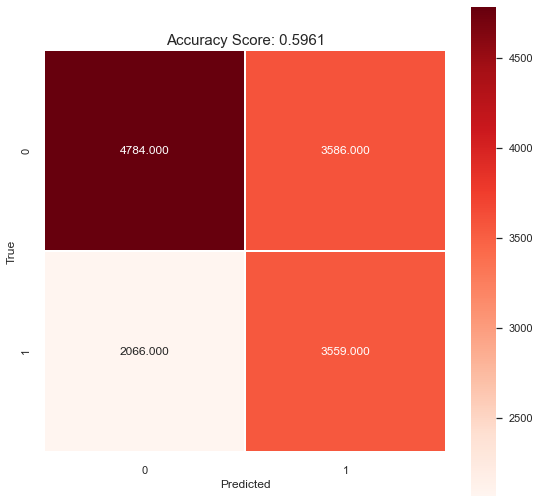

In [193]:
print("start plot")
cm, score = createConfMatrix(rf,y_test_Active, y_pred_rf, x_test_Active) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM.png')

In [194]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Random Forest"

## Call Function
summaryDF = summaryStats(model_name,y_test_Active,y_pred_rf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.5961,0.4981,0.6327,0.5574


Start RF ROC Plot


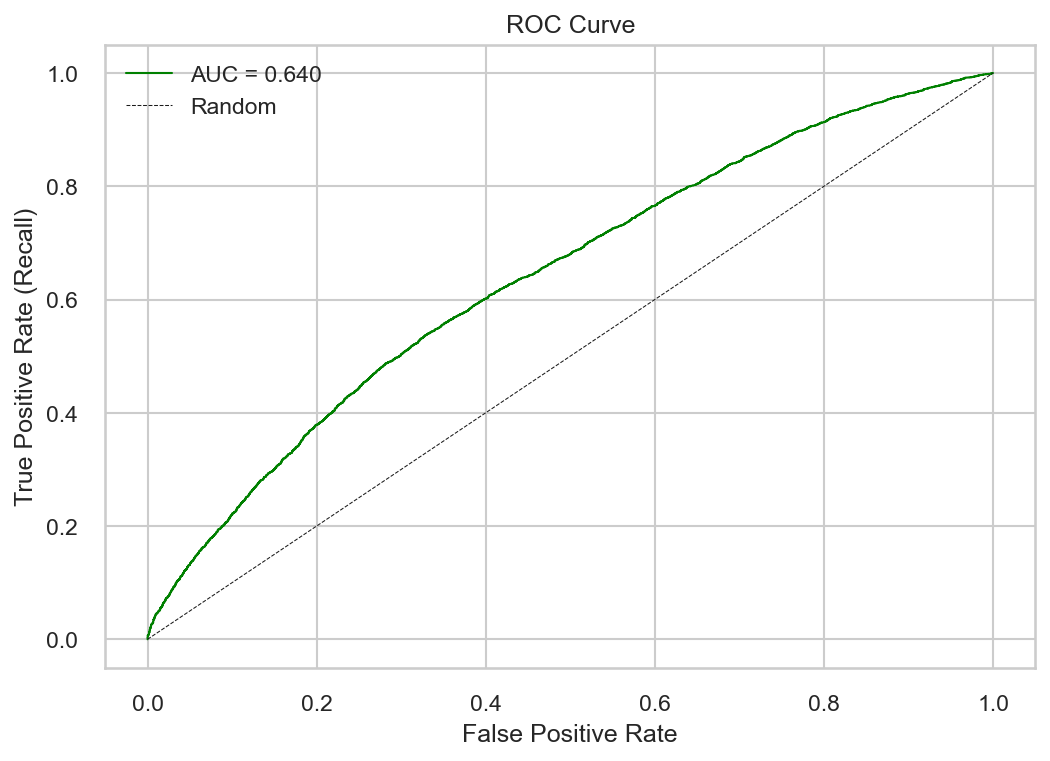

<Figure size 576x396 with 0 Axes>

In [195]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(rf,x_test_Active, y_test_Active) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'RF_ROC.png')

Start RF Feature Importance


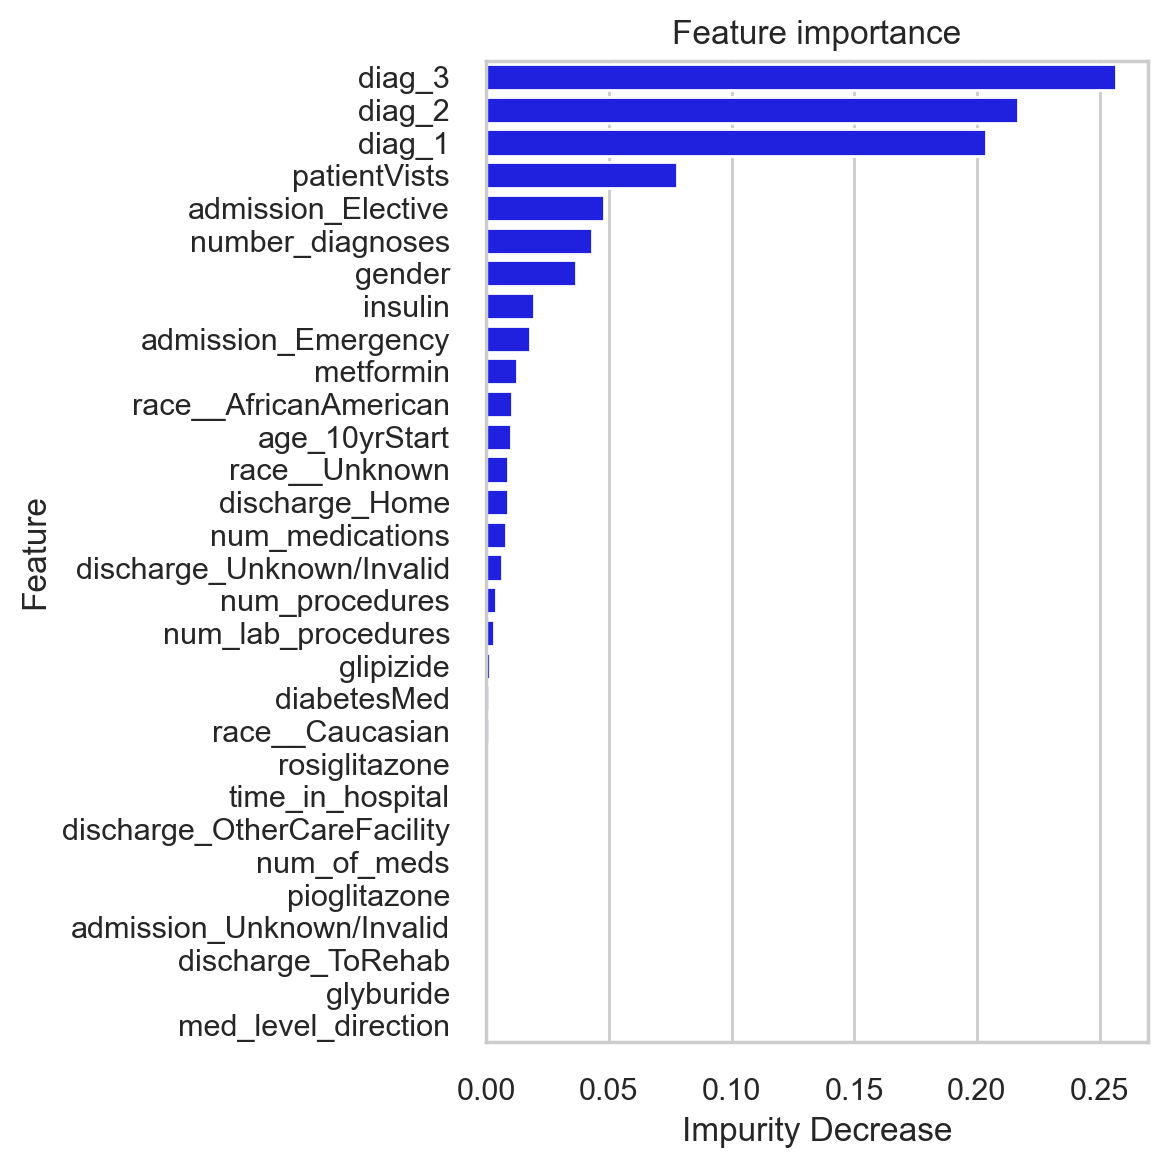

In [196]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF Feature Importance")

feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_Feature-Importance.png')

## Gradient Boosting

In [197]:
print("starting GB")
# Random Forest
## Set and Fit Model
## Setting when optimized for Accuracy
#gb = GradientBoostingClassifier(n_estimators=20, learning_rate=0.05,random_state=1,
 #                               max_depth=3, min_samples_split=75, max_features=4)

## Setting when optimized for Accuracy
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,random_state=1,
                                max_depth=10, min_samples_split=75, max_features=8)

gb.fit(x_train_Active,y_train_Active)

## Make Predictions
y_pred_gb = gb.predict(x_test_Active)
print("done predict gb")

starting GB
done predict gb


In [198]:
gb.get_params(deep=True)

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 10,
 'max_features': 8,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 75,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

start gb plot


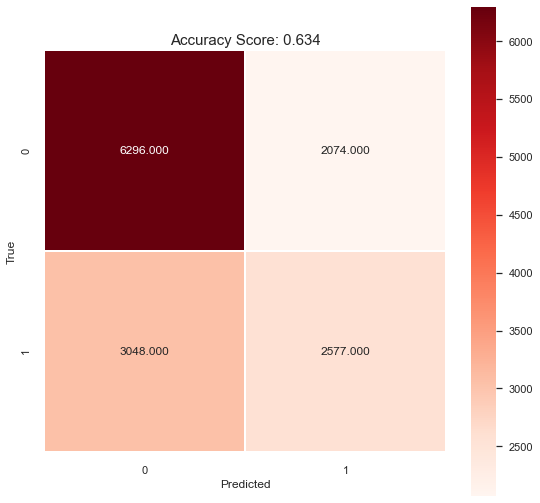

In [199]:
print("start gb plot")
cm, score = createConfMatrix(gb,y_test_Active, y_pred_gb, x_test_Active) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM.png')

In [200]:
#  GB -- Precision/Recall Scores

## Set Params
model_name = "Gradient Boost - Tuned for Accuracy"

## Call Function
summaryDF = summaryStats(model_name,y_test_Active, y_pred_gb, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.5961,0.4981,0.6327,0.5574
1,Gradient Boost - Tuned for Accuracy,0.6340,0.5541,0.4581,0.5016


Start GB ROC Plot


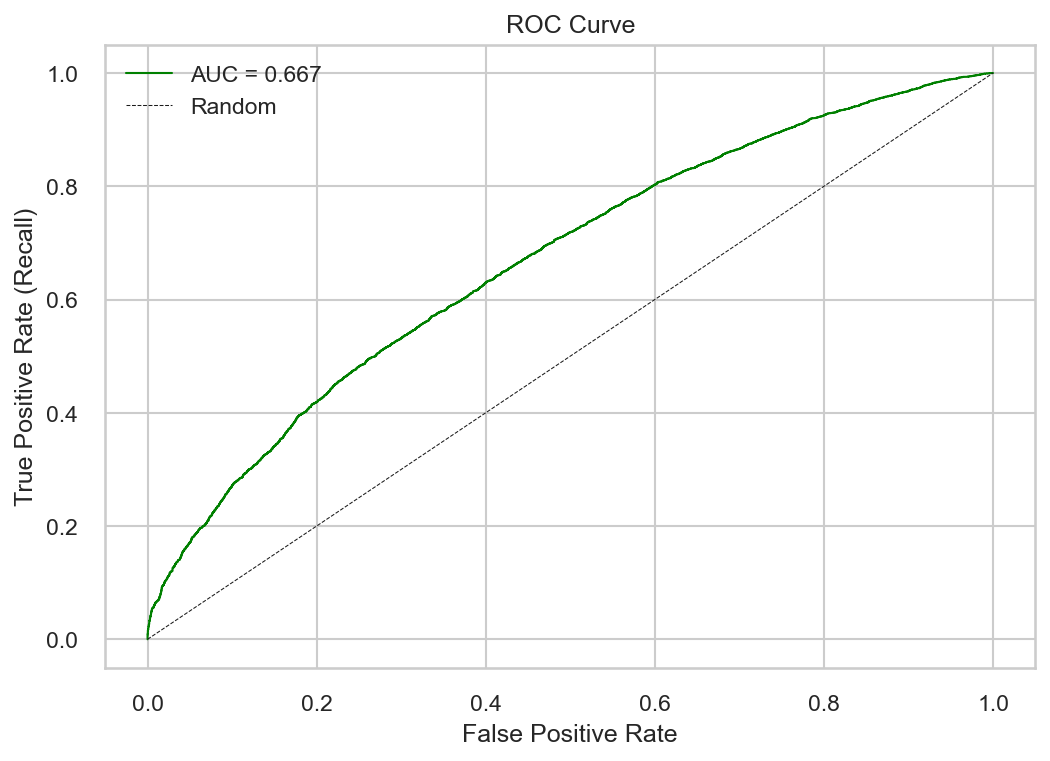

<Figure size 576x396 with 0 Axes>

In [201]:
# ROC Curve/ AUC Score
print("Start GB ROC Plot")

## Call Function
ROC_Curve_Plot(gb,x_test_Active, y_test_Active) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'GB_ROC.png')

Start GB Feature Importance


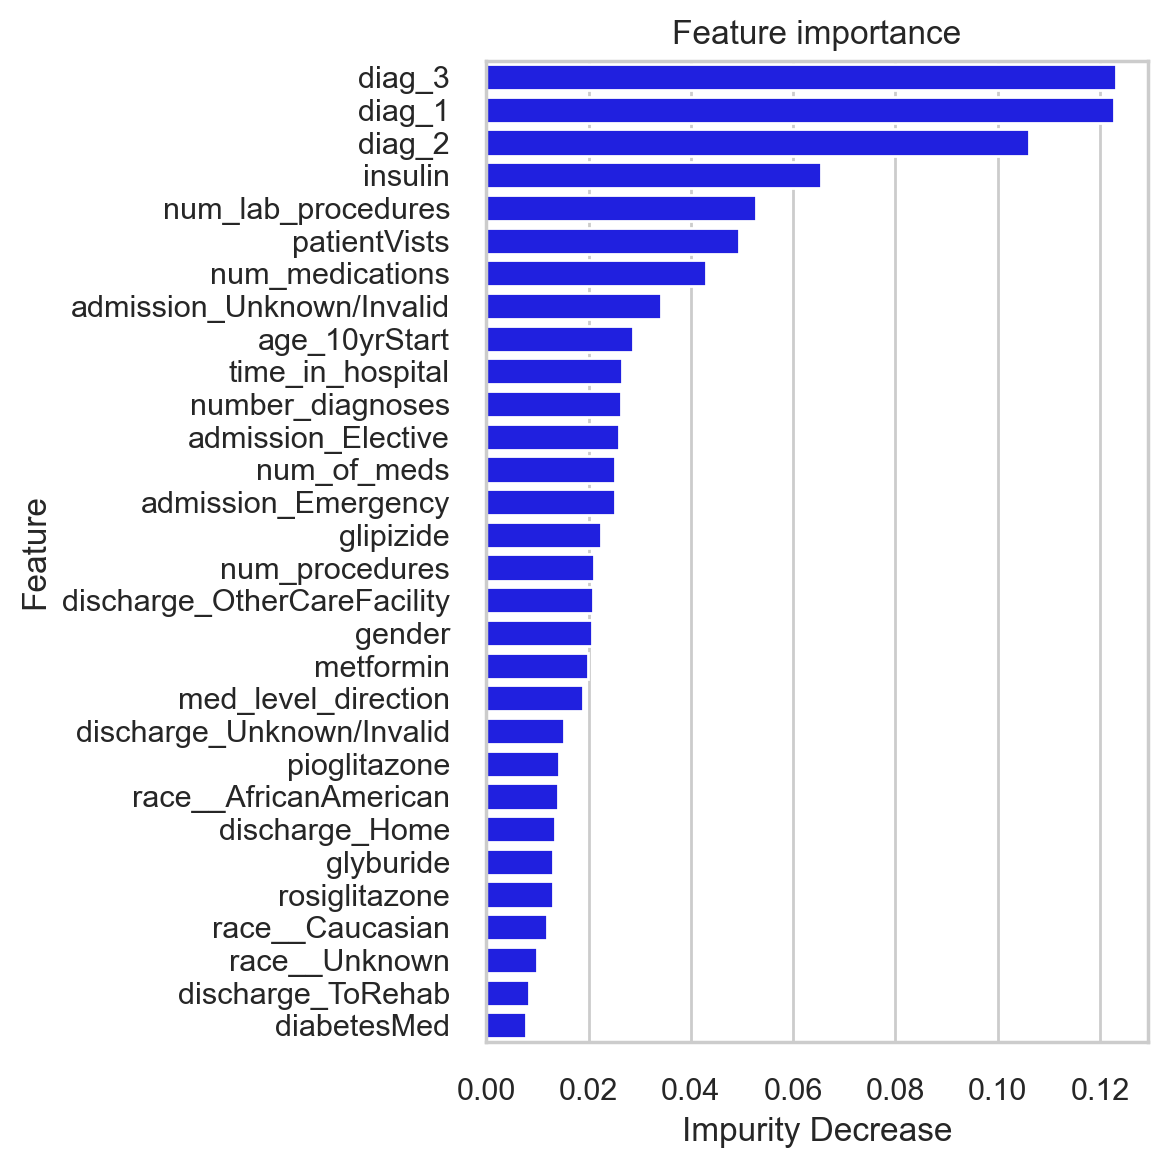

In [202]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start GB Feature Importance")

feature_importances, fig = FeatureImportance(gb,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'GB_Feature-Importance.png')

## GaussianNB

In [203]:
print("starting GaussianNB")
# GaussianNB
## Set and Fit Model
gnb = GaussianNB()
gnb.fit(x_train_Active,y_train_Active)

## Make Predictions
y_pred_gnb = gnb.predict(x_test_Active)
print("done predict gb")

starting GaussianNB
done predict gb


start gb plot


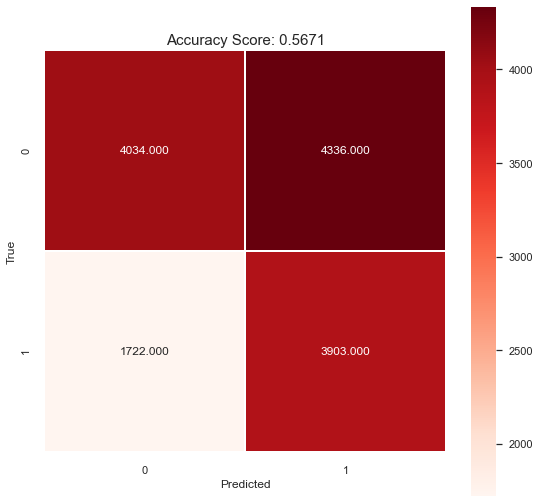

In [204]:
print("start gb plot")
cm, score = createConfMatrix(gnb,y_test_Active, y_pred_gnb, x_test_Active) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'GNB_CM.png')

In [205]:
# Random GB -- Precision/Recall Scores

## Set Params
model_name = "GaussianNB"

## Call Function
summaryDF = summaryStats(model_name,y_test_Active, y_pred_gnb, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.5961,0.4981,0.6327,0.5574
1,Gradient Boost - Tuned for Accuracy,0.6340,0.5541,0.4581,0.5016
2,GaussianNB,0.5671,0.4737,0.6939,0.5630


Start GNB ROC Plot


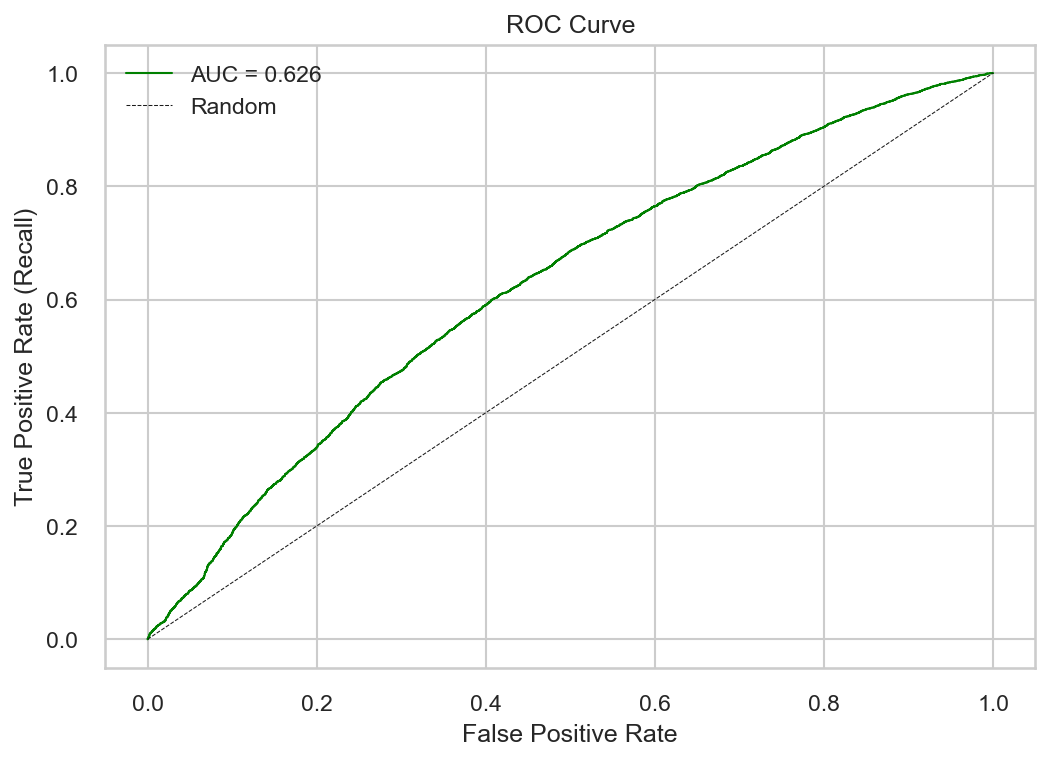

<Figure size 576x396 with 0 Axes>

In [206]:
# ROC Curve/ AUC Score
print("Start GNB ROC Plot")

## Call Function
ROC_Curve_Plot(gnb,x_test_Active, y_test_Active) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'GNB_ROC.png')

## Neural Network

In [207]:
print("starting N.N. Classifier")
nn = MLPClassifier(max_iter=300,activation="tanh",random_state=1,hidden_layer_sizes=(100,),
                   learning_rate='adaptive',alpha=0.05,solver='sgd')


nn.fit(x_train_Active, y_train_Active)
y_pred_nn = nn.predict(x_test_Active)
print(nn.score(x_test_Active, y_test_Active))

starting N.N. Classifier
0.6352268667381208


start plot


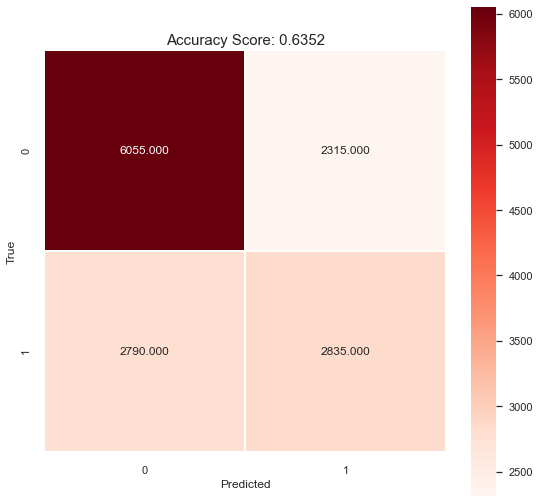

In [208]:
# N.N -- Plot CM
print("start plot")
cm, score = createConfMatrix(nn,y_test_Active, y_pred_nn, x_test_Active) #model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'NN_CM.png')

In [209]:
# N.N -- Precision/Recall Scores
## Set Params
model_name = "Neural Network Re-Tuned"

## Call Function
summaryDF = summaryStats(model_name,y_test_Active, y_pred_nn, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.5961,0.4981,0.6327,0.5574
1,Gradient Boost - Tuned for Accuracy,0.6340,0.5541,0.4581,0.5016
2,GaussianNB,0.5671,0.4737,0.6939,0.5630
3,Neural Network Re-Tuned,0.6352,0.5505,0.5040,0.5262


N.N ROC Plot


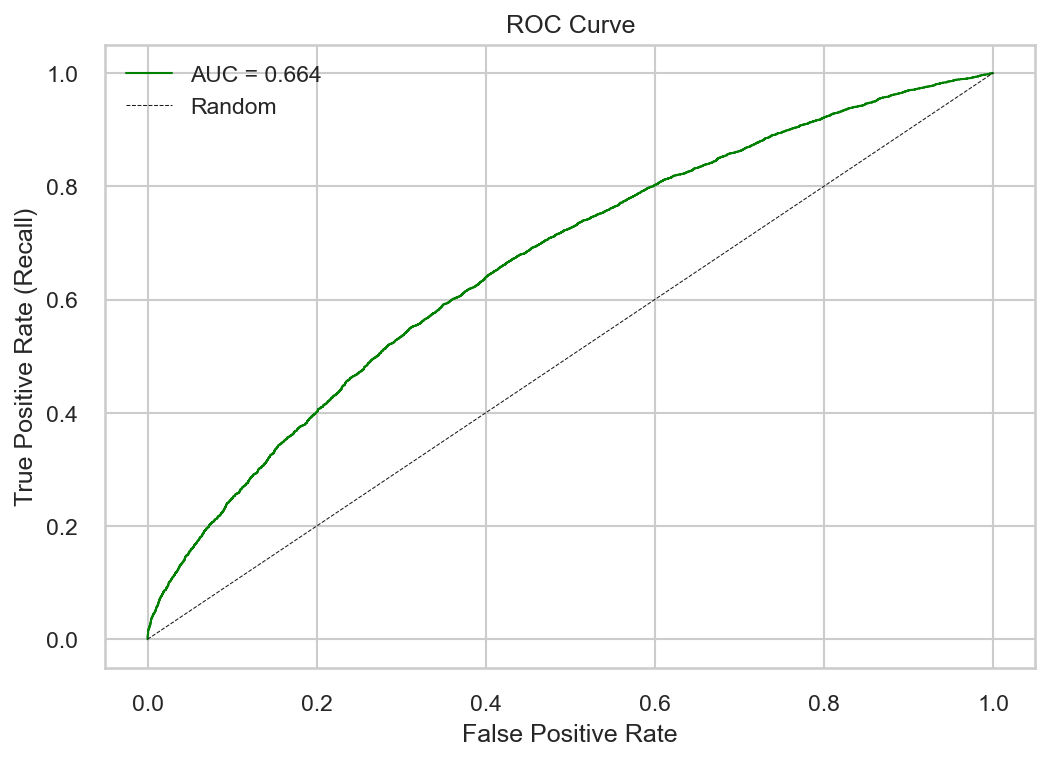

<Figure size 576x396 with 0 Axes>

In [210]:
# ROC Curve/ AUC Score
print("N.N ROC Plot")

## Call Function
ROC_Curve_Plot(nn,x_test_Active, y_test_Active) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'NN_ROC.png')

## Ensemble Method

In [211]:
#create a dictionary of our models
estimators=[('RandFor',rf),('Gaussian_NB',gnb),('GradBoost',gb),('NeuNet',nn)] # rf,gnb,gb,nn

#create our voting classifier, inputting our models
eclf = VotingClassifier(estimators,weights=[1,1,1,1],voting='soft') #

# fit model to training data
eclf.fit(x_train_Active, y_train_Active)

# Make Predictions
y_pred_eclf = eclf.predict(x_test_Active)
print("done predict eclf")

done predict eclf


start eclf plot


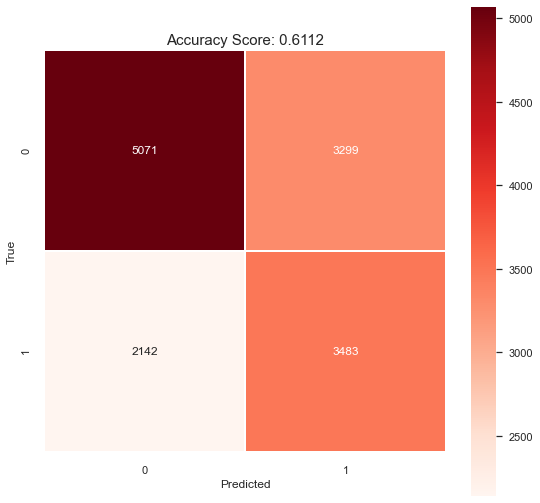

In [212]:
print("start eclf plot")
cm, score = createConfMatrix(eclf,y_test_Active, y_pred_eclf, x_test_Active) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'eclf_CM.png')

In [213]:
# Random GB -- Precision/Recall Scores

## Set Params
model_name = "Ensemble: Tuned NN"

## Call Function
summaryDF = summaryStats(model_name,y_test_Active, y_pred_eclf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.5961,0.4981,0.6327,0.5574
1,Gradient Boost - Tuned for Accuracy,0.6340,0.5541,0.4581,0.5016
2,GaussianNB,0.5671,0.4737,0.6939,0.5630
3,Neural Network Re-Tuned,0.6352,0.5505,0.5040,0.5262
4,Ensemble: Tuned NN,0.6112,0.5136,0.6192,0.5615


Start Ensemble ROC Plot


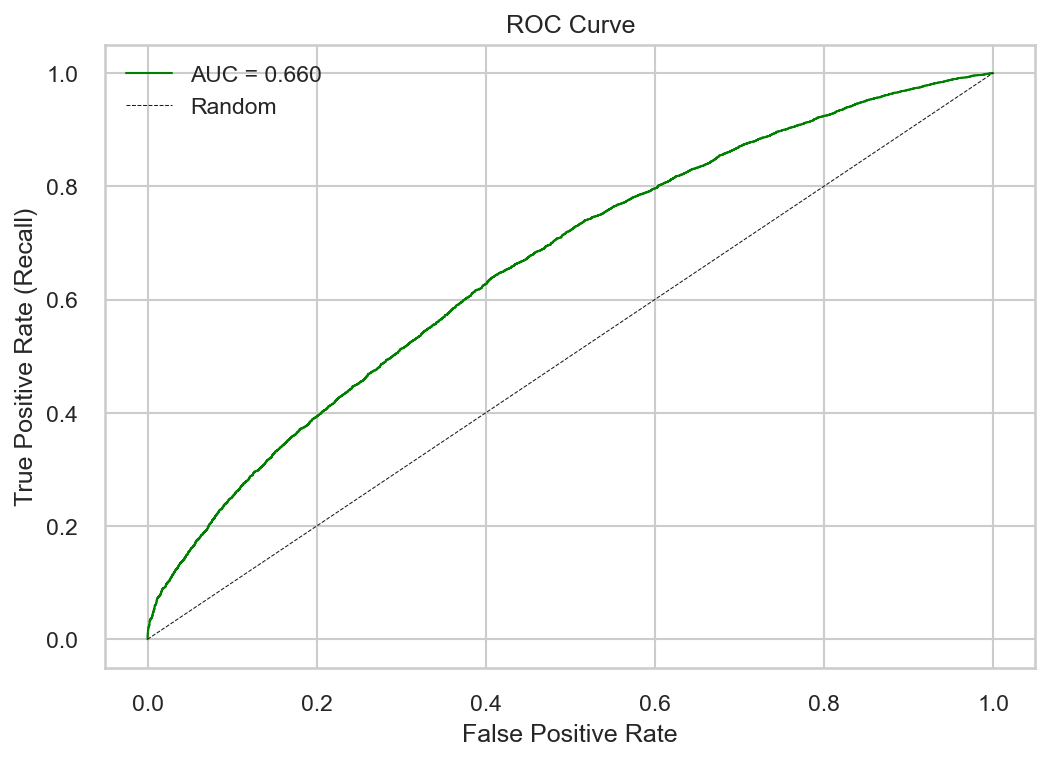

<Figure size 576x396 with 0 Axes>

In [214]:
# ROC Curve/ AUC Score
print("Start Ensemble ROC Plot")

## Call Function
ROC_Curve_Plot(eclf,x_test_Active, y_test_Active) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'eclf_ROC.png')


## Compare all Models

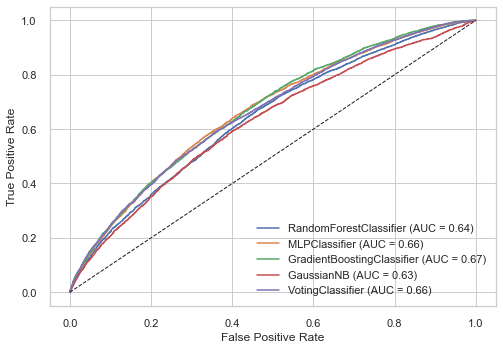

In [215]:
# Compare ROC's/AUC's
# Plot First Model:
disp = plot_roc_curve(rf,x_test_Active,y_test_Active)
# To Add More Models, copy line below and replace model name:
plot_roc_curve(nn,x_test_Active,y_test_Active, ax=disp.ax_)
plot_roc_curve(gb,x_test_Active,y_test_Active, ax=disp.ax_)
plot_roc_curve(gnb,x_test_Active,y_test_Active, ax=disp.ax_)
plot_roc_curve(eclf,x_test_Active,y_test_Active, ax=disp.ax_)
#plot_roc_curve(ensemble,x_test_Active,y_test_Active, ax=disp.ax_)
# plot Random Line
plt.plot([0,1], [0,1], '--k', lw=1.0, label='Random')
plt.savefig(plotLoc +'ROC-Compare.png')

In [216]:
## Combined Feature Importance Plot

rf_importances = rf.feature_importances_
rf_forest_importances = pd.Series(rf_importances, index=featureList)
rf_forest_importances = rf_forest_importances.to_frame().reset_index()
rf_forest_importances = rf_forest_importances.rename(columns={'index':'feature',0:'impDecrease'})
rf_forest_importances = rf_forest_importances.sort_values(by='impDecrease',ascending=False)
rf_forest_importances['Model'] = "Random Forest"

gb_importances = gb.feature_importances_
gb_forest_importances = pd.Series(gb_importances, index=featureList)
gb_forest_importances = gb_forest_importances.to_frame().reset_index()
gb_forest_importances = gb_forest_importances.rename(columns={'index':'feature',0:'impDecrease'})
gb_forest_importances = gb_forest_importances.sort_values(by='impDecrease',ascending=False)
gb_forest_importances['Model'] = "Gradient Boosting"

feature_importances_comb = rf_forest_importances.append(gb_forest_importances, ignore_index=True)


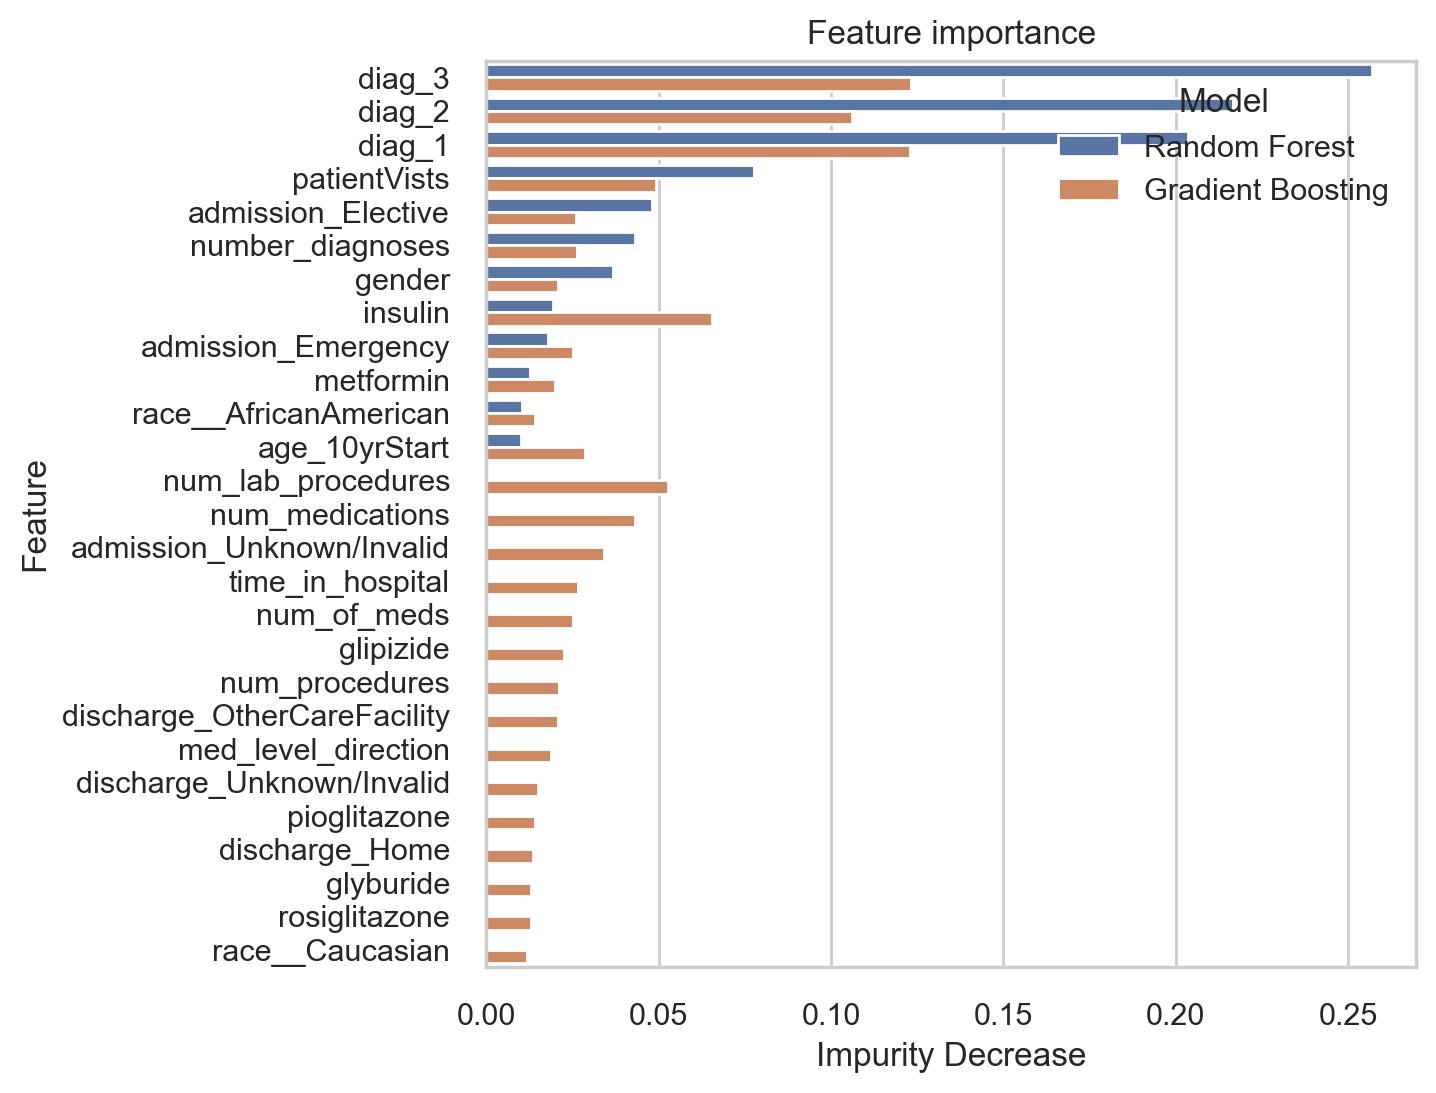

In [217]:
index_names = feature_importances_comb[ feature_importances_comb['impDecrease'] <= 0.01 ].index

# drop these row indexes
# from dataFrame
feature_importances_comb.drop(index_names, inplace = True)
feature_importances_comb

# Create Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (6,6), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature", hue="Model",
                  data=feature_importances_comb)
#plt.vlines(x = 0.01, ymin = -1, ymax = 17.0, color = 'black', linewidth=1)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")

plt.savefig(plotLoc +'Combined-Feature-Importance.png')

In [218]:
# Write Summary Reports to Excel
with pd.ExcelWriter(exportPath + 'Model_Eval.xlsx') as writer:
    #qe_summaryDF.to_excel(writer, sheet_name='QuickEval_noPCA')
    # qe_summaryDF_wPCA.to_excel(writer, sheet_name='QuickEval_PCA')
    summaryDF.to_excel(writer, sheet_name='Full-Model-Summary')
print("Export Complete")

Export Complete


# Model Tuning

In [219]:
# Intential Break Point -- This code takes a long time to run, only use when tuning parameters.
break

SyntaxError: 'break' outside loop (<ipython-input-219-c33dfeb8bb5f>, line 2)

In [ ]:
def grid_search_wrapper(refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train_Active, y_train_Active)

    # make the predictions
    y_pred = grid_search.predict(x_test_Active)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test_Active, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

## Tuning RF

In [ ]:
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_split = [1, 2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [ ]:
print("started...")
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
rf_random.fit(x_train_pca, y_train_pca)
print("done")

In [ ]:
rf_random.best_params_

In [ ]:
print (rf_random.score(x_train_pca, y_train_pca))
print(rf_random.score(x_test_pca, y_test_pca))


## RF Tuning 2

In [ ]:
rf.get_params(deep=True)

In [ ]:
clf = RandomForestClassifier()

param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'max_depth': [3,5,10,20],
    'n_estimators': [100,500,1000],
    'max_leaf_nodes':[16,32,64,96],
    'criterion':['gini','entropy']
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')
grid_search_clf

RF_Best_Params = grid_search_clf.best_params_


import json
# as requested in comment
RF_Best_Params = {'exDict': RF_Best_Params}

with open('RF_Best_Params.txt', 'w') as file:
     file.write(json.dumps(RF_Best_Params))

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = rf.predict_proba(x_test_Active)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test_Active, y_scores)
print("done")

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
plt.savefig(plotLoc +'RRF_Decision-Thresh.png')

## GB Tuning

In [ ]:
gb.get_params(deep=True)

In [ ]:
clf = GradientBoostingClassifier(verbose=2)

param_grid = {
    'min_samples_split': [10,50,75],
    'n_estimators' : [20,50,100],
    'max_depth': [3,6,10],
    'max_features': [4,8,10],
    'learning_rate':[0.05,0.1,0.2,0.3,0.5,0.99]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
print("ready2")

In [ ]:
print("running2...")
refit_score='recall_score'
grid_search_clf = grid_search_wrapper(refit_score)
grid_search_clf

GB_Best_Params = grid_search_clf.best_params_

print("printing...")

# as requested in comment
GB_Best_Params = {'exDict': GB_Best_Params}

with open('GB_Best_Params_Recall.txt', 'w') as file:
     file.write(json.dumps(GB_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test_Active)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test_Active, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
plt.savefig(plotLoc +'GB_Decision-Thresh.png')

## Tuning NN

In [ ]:
nn.get_params(deep=True)

In [ ]:
mlp_gs = MLPClassifier()
parameter_space = {
    'hidden_layer_sizes': [(20,),(50,),(100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs','sgd','adam'],
    'alpha': [0.0001,0.001, 0.05],
    'learning_rate': ['constant','invscaling','adaptive'],
    'max_iter': [100,200,300]
}

print("running...")
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5,verbose=2)
clf.fit(x_test_Active, y_test_Active)
print("done")

NN_Best_Params = clf.best_params_
NN_Best_Params = {'exDict': NN_Best_Params}

with open('NN_Best_Params.txt', 'w') as file:
     file.write(json.dumps(NN_Best_Params))

## Unimplemented Draft Ideas

In [ ]:
cleanDF

In [ ]:
cleanDF['num_meds_changed'] = (cleanDF[medCols] == 1).sum(axis=1) + \
                                  (cleanDF[medCols] == 3).sum(axis=1)
cleanDF['num_meds_changed'].value_counts()

## K-Means Clustering

In [ ]:
# Make a copy of the DF
k_means_df = tempModelingDF
k_means_df = k_means_df.drop(columns=['readmitted'])


In [ ]:
# Call Elbow Plot Function
KMeansElbowPlot(k_means_df)
plt.show()

In [ ]:
# K-Means - set number of clusters based on elbow
km = KMeans(n_clusters=4)
km

In [ ]:
# Scale Data using min max scaler

scaler = MinMaxScaler()
colNames = k_means_df.columns.values.tolist()

for column in k_means_df[colNames]:
    scaler.fit(k_means_df[[column]])
    k_means_df[column] = scaler.transform(k_means_df[[column]])

k_means_df.head()

In [ ]:
# Re-Train Dataset using Scaled Data
y_predicted = km.fit_predict(k_means_df[colNames])
k_means_df['Cluster'] = y_predicted
k_means_df['Cluster'].value_counts(dropna=False)

In [ ]:
#Merge clusters ("Temp") back with the preserved original DF
tempModelingDF = pd.merge(tempModelingDF, k_means_df[['Cluster']], left_index=True, right_index=True)
tempModelingDF.head()

#### Summary -- Describe Clusters

* Some ideas: https://www.bigendiandata.com/2017-04-18-Jupyter_Customer360/

# Experimentation/ Scratchpad

In [ ]:
responseVar = 'readmitted'
corr = round(tempModelingDF.corr(),4)
corr = abs(corr[responseVar]).sort_values(ascending=False)

#Selecting highly correlated features
relevant_features = corr[corr>=0.04] # Look for Features w/ greater 0.05 cor
relevant_features

In [ ]:
#TEMP - Reduce to corrlated features.  If use this, then need to implement in a way that isn't manually keying in.
relevant_features_df = tempModelingDF[['readmitted','number_inpatient','number_emergency',
                                                      'age_10yrStart','number_outpatient','time_in_hospital',
                                                      'num_lab_procedures']]
relevant_features_df


In [ ]:
mainData['gender'].value_counts(dropna=False)

In [ ]:
expVars = ['num_of_meds','med_level_direction','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
            'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
            'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide',
            'citoglipton','insulin','glyburide.metformin','glipizide.metformin','glimepiride.pioglitazone',
            'metformin.rosiglitazone','metformin.pioglitazone','readmitted']

expSummaryVars = ['num_of_meds','med_level_direction','readmitted']

tempCor = mainData[expSummaryVars]
tempCor.sample(5)

In [ ]:
#Multiple Regression -- Check Correlations in HeatMap
plt.figure(figsize=(12,10))
cor = round(tempCor.corr(),3)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [ ]:
#Multiple Regressions -- Correlation with output variable
responseVar = 'readmitted'
cor_target = abs(cor[responseVar])
#Selecting highly correlated features
#relevant_features = cor_target[cor_target>=0.01] # Look for Features w/ greater 0.05 cor
#relevant_features
cor_target


# Archive

## PCA

In [ ]:
# PCA - Create New Train/Test Sets
x_train_pca = x_train
y_train_pca = y_train
x_test_pca = x_test
y_test_pca = y_test

# PCA Pre-Run on Complete Dataframe to Identify right Hyperparams
df = tempModelingDF
PCA_relevant_features = ['time_in_hospital','num_lab_procedures',
                    'num_medications','number_outpatient','number_emergency','number_inpatient',
                    'number_diagnoses','num_procedures',]
# parking lot: 'num_of_meds','age_10yrStart'

PCA_ResponseVar = 'readmitted'

PCA_PreProcess_Elbow(df,PCA_relevant_features,PCA_ResponseVar)
plt.show()

In [ ]:
# Call PCA Function for Test/Train Sets.  Also returns new Predictor Var list for use in later models

features = PCA_relevant_features
PCs = 2

x_train_pca, PredictorVar_pca = PCA_Actual(x_train_pca,features,PCs) # set, features for PCA, number of P.Cs
x_test_pca, PredictorVar_pca = PCA_Actual(x_test_pca,features,PCs) # set, features for PCA, number of P.Cs

## K-Means Clustering

In [ ]:
# Make a copy of the DF
k_means_df = tempModelingDF
k_means_df = tempModelingDF.drop(columns=['readmitted'])


In [ ]:
# Call Elbow Plot Function
KMeansElbowPlot(k_means_df)
plt.show()

In [ ]:
# K-Means - set number of clusters based on elbow
km = KMeans(n_clusters=3)
km

In [ ]:
# Scale Data using min max scaler

scaler = MinMaxScaler()
colNames = k_means_df.columns.values.tolist()

for column in k_means_df[colNames]:
    scaler.fit(k_means_df[[column]])
    k_means_df[column] = scaler.transform(k_means_df[[column]])

k_means_df.head()

In [ ]:
colNames = k_means_df.columns.values.tolist()

# Re-Train Dataset using Scaled Data
y_predicted = km.fit_predict(k_means_df[colNames])
k_means_df['Cluster'] = y_predicted
k_means_df['Cluster'].value_counts(dropna=False)

In [ ]:
#Merge clusters ("Temp") back with the preserved original DF
tempModelingDF = pd.merge(tempModelingDF,k_means_df[['Cluster']],left_index=True, right_index=True)
tempModelingDF.head()

In [ ]:
dummyTemp_kmeans = pd.get_dummies(tempModelingDF['Cluster'],prefix='Cluster')
tempModelingDF = tempModelingDF.join(dummyTemp_kmeans)
tempModelingDF = tempModelingDF.drop(columns=['Cluster'])
tempModelingDF.head()

## Initial Model Evaluation

In [ ]:
# Initial Quick Eval - W/O PCA
## Commented out because purpose has been served for first tier model selection

# Create DF for Capturing Model Results
# statRow = []
# qe_summaryDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

# Set models
# rf_qe = RandomForestClassifier(n_estimators=500, max_leaf_nodes=32,n_jobs=-1)
# nn_qe = MLPClassifier(activation="relu",random_state=1) #TODO: Start Small - hidden_layer_sizes=(256,128,64,32)
# knn_qe = KNeighborsClassifier(n_neighbors=2)
# gb_qe = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0)
# gnb_ce = GaussianNB()

# Models List
# models = [rf_qe,nn_qe,knn_qe,gb_qe,gnb_ce]

## Call Function
# qe_summaryDF = quickModelComparison(models,x_train, x_test,
                                   # y_train, y_test, qe_summaryDF ) # model list, X sets, y sets, summary df

# print("quick evaluation report with vanilla test/train split:")
# qe_summaryDF

In [ ]:
# Initial Quick Eval w/ PCA
## Commented out because purpose has been served for first tier model selection

# Create DF for Capturing Model Results
# statRow = []
# qe_summaryDF_wPCA = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

# Set models -- USES SAME AS EVAL w/o PCA ABOVE

# Models List -- USES SAME AS EVAL w/o PCA ABOVE
# models = [rf_qe,nn_qe,gb_qe, gnb_ce]

## Call Function
# qe_summaryDF_wPCA = quickModelComparison(models,x_train_pca, x_test_pca,
                                         # y_train_pca, y_test_pca,qe_summaryDF_wPCA ) # model list, X sets, y sets, summary df
# print("quick evaluation report with test/train split with PCA:")
# qe_summaryDF_wPCA


## Code to Adjust threshold levels for predictions.
Experimented extensively, but never got better results.

In [ ]:

predictions =  rf.predict_proba(x_test_Active)
predictions


In [ ]:
temp = pd.DataFrame(predictions)
temp['threshold'] = 0
temp = temp.rename(columns={0:"lower",1:"upper"})
temp.loc[temp['upper'] >= 0.4,"threshold"] =1
temp['threshold']


In [ ]:
# Expermiment -  Feature Engineer Diag Codes

## TEMP -- Until I figure out how to deal with multiple Diags, drop 2 and 3 to just see if this is worthwhile
#cleanDF = cleanDF.drop(columns=['diag_2','diag_3'])

In [ ]:
# Expermiment -  Feature Engineer Diag Codes

def map_diagnosis(data, cols):
    for col in cols:
        data.loc[(data[col].str.contains("V")) | (data[col].str.contains("E")), col] = -1
        data[col] = data[col].astype(np.float16)

    for col in cols:
        data['temp'] = np.nan
        data.loc[(data[col]== -1), 'temp'] = "PreventativeCare"
        data.loc[(data[col]>=1) & (data[col]<=139), 'temp'] = "InfectiousDisease"
        data.loc[(data[col]>=140) & (data[col]<=239), 'temp'] = "Neoplasms"
        data.loc[(data[col]>=240) & (data[col]<=279), 'temp'] = "ENMIDisorders"
        data.loc[(data[col]>=280) & (data[col]<=289) | (data[col] == 790), 'temp'] = "BloodDisease"
        data.loc[(data[col]>=290) & (data[col]<=319), 'temp'] = "MentalDisorder"
        data.loc[(data[col]>=320) & (data[col]<=389) | (data[col]==781), 'temp'] = "NervousSystem"
        data.loc[(data[col]>=390) & (data[col]<=459) | (data[col]==785), 'temp'] = "Circulatory"
        data.loc[(data[col]>=460) & (data[col]<=519) | (data[col]==786), 'temp'] = "Respiratory"
        data.loc[(data[col]>=520) & (data[col]<=579) | (data[col]==787), 'temp'] = "Digestive"
        data.loc[(data[col]>=580) & (data[col]<=629) | (data[col] == 788), 'temp'] = "Genitourinary"
        data.loc[(data[col]>=630) & (data[col]<=679) , 'temp'] = "Pregnacy-Childbirth"
        data.loc[(data[col]>=680) & (data[col]<=709) | (data[col]==782), 'temp'] = "SkinDisease"
        data.loc[(data[col]>=710) & (data[col]<=739), 'temp'] = "Muscoloskeletal"
        data.loc[(data[col]>=740) & (data[col]<=759), 'temp'] = "CongenitalAnomalies"
        data.loc[(data[col]>=760) & (data[col]<=779) , 'temp'] = "Pregnacy-Childbirth"
        data.loc[(data[col]>=800) & (data[col]<=999), 'temp'] = "Injury"

        data['temp'] = data['temp'].fillna('Other')
        data[col] = data['temp']
        data = data.drop('temp', axis=1)

    return data

In [ ]:
#cleanDF['temp_diag'] = cleanDF['diag_1']
#cleanDF = map_diagnosis(cleanDF,['temp_diag'])
#cleanDF['temp_diag'].value_counts(dropna=False)

In [ ]:
#temp = cleanDF[cleanDF['temp_diag'] == 'Other']
#temp['diag_1'].value_counts()

In [ ]:
# Expermiment -  Feature Engineer Diag Codes

### Dummy Encode
#dummyTemp_diag = pd.get_dummies(cleanDF['temp_diag'],prefix='diag')
#cleanDF = cleanDF.join(dummyTemp_diag)
#cleanDF = cleanDF.drop(columns=['temp_diag','diag_1']) # Drop Old diag Column
#cleanDF

In [ ]:
# Expermiment -  Blender

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
print("starting2")
layer_one_estimators = [
                        ('gb_1', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,random_state=1,
                                max_depth=10, min_samples_split=75, max_features=8)),
                        ('rf_1', RandomForestClassifier(n_estimators=100, max_leaf_nodes=96, min_samples_split=10, max_depth=3,
                                                        max_features='sqrt',criterion='gini',n_jobs=-1)),
                       ]

layer_two_estimators = [
                        ('gnb_1', GaussianNB())
                       ]

#('nn_1', MLPClassifier(max_iter=100,activation="relu",random_state=1,hidden_layer_sizes=(20,),
  #                                             learning_rate='adaptive',alpha=0.0001,solver='adam'))

layer_two = StackingClassifier(estimators=layer_two_estimators,
                               final_estimator=LogisticRegression())

# Create Final model by
blend = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)
blend.fit(x_train_Active, y_train_Active)
print("done")

In [ ]:
# Make Predictions
print("Starting...")
y_pred_blend = blend.predict(x_test_Active)
print("done predict eclf2")

In [ ]:
print("start eclf plot")
cm, score = createConfMatrix(eclf,y_test_Active, y_pred_blend, x_test_Active) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'eclf_CM.png')

In [ ]:
# Random GB -- Precision/Recall Scores

## Set Params
model_name = "Blend"

## Call Function
summaryDF = summaryStats(model_name,y_test_Active, y_pred_blend, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

In [ ]:
# ROC Curve/ AUC Score
print("Start Ensemble ROC Plot")

## Call Function
ROC_Curve_Plot(blend,x_test_Active, y_test_Active) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'blend_ROC.png')
